# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [1]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [2]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    #lr=0.001
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '/home/next/Quantum/Quantum-machine-learning-for-high-dimensional-data/input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [4]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import Parameter, ParameterVector

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

In [5]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [6]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [7]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [8]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
from qiskit.circuit.library.standard_gates import RXGate, RYGate, MCXGate

def incrementor(nq):
    qc = QuantumCircuit(nq)
    for i in range(nq,0,-1):
        if i == 1:
            qc.x(0)
        else:
            qc.append(MCXGate(i-1),range(i))
    return qc

def decrementor(nq):
    qc = QuantumCircuit(nq)
    for i in range(nq):
        if i == 0:
            qc.x(0)
        else:
            qc.append(MCXGate(i),range(i+1))
    return qc

In [10]:
parameters = ParameterVector('theta', length=(2))
def multi_conditional_shift_operator_right(Num_CoinQubits, Num_PositionQubits):
    # Define your shift operator using trainable parameters
    shift_operator = QuantumCircuit(Num_CoinQubits + Num_PositionQubits, name='ShiftOperator')

    # Apply controlled rotations based on parameters
    for i, param in enumerate(parameters):
        shift_operator.ry(param, i)

    return shift_operator

def multi_conditional_shift_operator_left(Num_CoinQubits, Num_PositionQubits):
    # Define your shift operator using trainable parameters
    shift_operator = QuantumCircuit(Num_CoinQubits + Num_PositionQubits, name='ShiftOperator')

    # Apply controlled rotations based on parameters
    for i, param in enumerate(parameters):
        shift_operator.ry(param, i)

    return shift_operator


def QW_with_multicoin(Num_CoinQubits, Num_PositionQubits):
    qr_x = QuantumRegister(Num_PositionQubits, name="x")
    qr_c = QuantumRegister(Num_CoinQubits, name="c")
    #cr = ClassicalRegister(Num_PositionQubits, name="cbits")
    circ = QuantumCircuit(qr_x, qr_c)

    shift_right = multi_conditional_shift_operator_right(Num_CoinQubits, Num_PositionQubits)
    shift_left = multi_conditional_shift_operator_left(Num_CoinQubits, Num_PositionQubits)
    # Initialize coin qubits with trainable parameters
    for i in range(Num_CoinQubits):
        circ.ry(parameters[i], qr_c[i])
        for j in range(i):
            circ.cx(qr_c[i], qr_c[j])

    circ.barrier()

    # Apply S+
    circ.append(shift_right, range(Num_CoinQubits + Num_PositionQubits))

    circ.barrier()

    # Update coin qubits with new parameters
    for i in range(Num_CoinQubits):
        circ.ry(parameters[i], qr_c[i])
        for j in range(i):
            circ.cx(qr_c[i], qr_c[j])

    circ.barrier()

    # Apply S-
    circ.append(shift_left, range(Num_CoinQubits + Num_PositionQubits))

    #circ.measure(qr_x, cr)
    
    # Only return the classical register
    return circ

In [11]:
# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=2
def create_qnn():
    #feature_map = ZFeatureMap(nq, reps=2)
    feature_map = QW_with_multicoin(Num_CoinQubits=1, Num_PositionQubits=1)
    ansatz = RealAmplitudes(1, reps=2)
    qc = QuantumCircuit(nq)
    # Only compose the quantum circuit quantum register
    qc.compose(feature_map, inplace=True)
    # Place ansatz on the quantum register q0 to q1
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        output_shape=0,
    )
    
    return qnn

qnn = create_qnn()

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


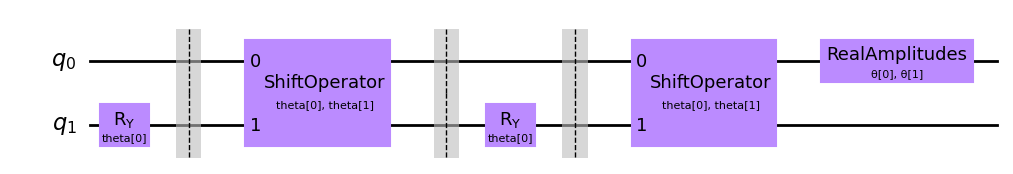

In [12]:
#feature_map = ZFeatureMap(nq, reps=2)
feature_map = QW_with_multicoin(Num_CoinQubits=1, Num_PositionQubits=1)
ansatz = RealAmplitudes(1, reps=1)
qc = QuantumCircuit(nq)
# Only compose the quantum circuit quantum register
qc.compose(feature_map, inplace=True)
# Place ansatz on the quantum register q0 to q1
qc.compose(ansatz, inplace=True)
qc.draw('mpl')

In [13]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, nq)    
        # Continue to write your own cnn layers
        #self.relu = nn.ReLU()
        #self.conv1d = nn.Conv1d(512, 256, kernel_size=3, padding=1)

        self.qnn = TorchConnector(qnn)
        #self.fc2 = nn.Linear(pow(2, nq), 2)

        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        #x = self.fc2(x)

        return x

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [15]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [16]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()


In [17]:
if __name__ == '__main__':
    main(0)

========== training ==========


Epoch: [1][1/192] Data 0.332 (0.332) Elapsed 0m 2s (remain 8m 52s) Loss: 1.5584(1.5584) Grad: 30.3481  
Epoch: [1][101/192] Data 0.000 (0.003) Elapsed 0m 54s (remain 0m 48s) Loss: 0.9037(1.0391) Grad: 9.0414  
Epoch: [1][192/192] Data 0.000 (0.002) Elapsed 1m 39s (remain 0m 0s) Loss: 0.9815(0.9872) Grad: 9.3208  
EVAL: [1/49] Data 0.159 (0.159) Elapsed 0m 0s (remain 0m 11s) Loss: 0.9528(0.9528) 


Epoch 1 - avg_train_loss: 0.9872  avg_val_loss: 0.9426  time: 103s
Epoch 1 - Accuracy: 0.8498049414824448
Epoch 1 - Save Best Score: 0.8498 Model


EVAL: [49/49] Data 0.000 (0.004) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9441(0.9426) 
Epoch: [2][1/192] Data 0.233 (0.233) Elapsed 0m 1s (remain 3m 37s) Loss: 0.9283(0.9283) Grad: 15.3877  
Epoch: [2][101/192] Data 0.000 (0.003) Elapsed 0m 55s (remain 0m 50s) Loss: 0.8466(0.9202) Grad: 7.7966  
Epoch: [2][192/192] Data 0.000 (0.001) Elapsed 1m 43s (remain 0m 0s) Loss: 0.9641(0.9127) Grad: 8.1130  
EVAL: [1/49] Data 0.122 (0.122) Elapsed 0m 0s (remain 0m 10s) Loss: 0.9363(0.9363) 


Epoch 2 - avg_train_loss: 0.9127  avg_val_loss: 0.9116  time: 108s
Epoch 2 - Accuracy: 0.8517555266579974
Epoch 2 - Save Best Score: 0.8518 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0965(0.9116) 
Epoch: [3][1/192] Data 0.375 (0.375) Elapsed 0m 1s (remain 3m 41s) Loss: 0.9073(0.9073) Grad: 13.5684  
Epoch: [3][101/192] Data 0.000 (0.004) Elapsed 0m 55s (remain 0m 49s) Loss: 0.8368(0.9032) Grad: 15.9938  
Epoch: [3][192/192] Data 0.000 (0.002) Elapsed 1m 41s (remain 0m 0s) Loss: 0.9678(0.8988) Grad: 7.4975  
EVAL: [1/49] Data 0.129 (0.129) Elapsed 0m 0s (remain 0m 10s) Loss: 0.9040(0.9040) 


Epoch 3 - avg_train_loss: 0.8988  avg_val_loss: 0.9100  time: 105s
Epoch 3 - Accuracy: 0.864109232769831
Epoch 3 - Save Best Score: 0.8641 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0965(0.9100) 
Epoch: [4][1/192] Data 0.298 (0.298) Elapsed 0m 1s (remain 4m 4s) Loss: 0.8898(0.8898) Grad: 10.4629  
Epoch: [4][101/192] Data 0.000 (0.003) Elapsed 0m 50s (remain 0m 45s) Loss: 0.8374(0.8944) Grad: 8.9531  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 1m 33s (remain 0m 0s) Loss: 0.9650(0.8899) Grad: 6.3531  
EVAL: [1/49] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 10s) Loss: 0.9140(0.9140) 


Epoch 4 - avg_train_loss: 0.8899  avg_val_loss: 0.9049  time: 97s
Epoch 4 - Accuracy: 0.8745123537061118
Epoch 4 - Save Best Score: 0.8745 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0664(0.9049) 
Epoch: [5][1/192] Data 0.351 (0.351) Elapsed 0m 1s (remain 3m 41s) Loss: 0.8826(0.8826) Grad: 11.7276  
Epoch: [5][101/192] Data 0.000 (0.004) Elapsed 0m 49s (remain 0m 44s) Loss: 0.8268(0.8853) Grad: 6.4267  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 1m 36s (remain 0m 0s) Loss: 0.9411(0.8809) Grad: 5.7753  
EVAL: [1/49] Data 0.145 (0.145) Elapsed 0m 0s (remain 0m 11s) Loss: 0.8910(0.8910) 


Epoch 5 - avg_train_loss: 0.8809  avg_val_loss: 0.9012  time: 101s
Epoch 5 - Accuracy: 0.8673602080624188


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0584(0.9012) 
Epoch: [6][1/192] Data 0.382 (0.382) Elapsed 0m 1s (remain 3m 38s) Loss: 0.8778(0.8778) Grad: 13.7174  
Epoch: [6][101/192] Data 0.000 (0.004) Elapsed 0m 51s (remain 0m 46s) Loss: 0.8268(0.8790) Grad: 9.5742  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 1m 37s (remain 0m 0s) Loss: 0.9466(0.8758) Grad: 3.7782  
EVAL: [1/49] Data 0.146 (0.146) Elapsed 0m 0s (remain 0m 11s) Loss: 0.8877(0.8877) 


Epoch 6 - avg_train_loss: 0.8758  avg_val_loss: 0.8938  time: 101s
Epoch 6 - Accuracy: 0.8719115734720416


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0644(0.8938) 
Epoch: [7][1/192] Data 0.322 (0.322) Elapsed 0m 1s (remain 3m 59s) Loss: 0.8579(0.8579) Grad: 13.3886  
Epoch: [7][101/192] Data 0.000 (0.003) Elapsed 0m 53s (remain 0m 48s) Loss: 0.8226(0.8744) Grad: 10.1134  
Epoch: [7][192/192] Data 0.000 (0.002) Elapsed 1m 42s (remain 0m 0s) Loss: 0.9411(0.8709) Grad: 3.9705  
EVAL: [1/49] Data 0.131 (0.131) Elapsed 0m 0s (remain 0m 11s) Loss: 0.8772(0.8772) 


Epoch 7 - avg_train_loss: 0.8709  avg_val_loss: 0.8900  time: 106s
Epoch 7 - Accuracy: 0.8719115734720416


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0823(0.8900) 
Epoch: [8][1/192] Data 0.290 (0.290) Elapsed 0m 1s (remain 3m 30s) Loss: 0.8430(0.8430) Grad: 11.1057  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 0m 53s (remain 0m 47s) Loss: 0.8194(0.8703) Grad: 8.7181  
Epoch: [8][192/192] Data 0.000 (0.002) Elapsed 1m 38s (remain 0m 0s) Loss: 0.9329(0.8667) Grad: 6.1242  
EVAL: [1/49] Data 0.126 (0.126) Elapsed 0m 0s (remain 0m 11s) Loss: 0.8714(0.8714) 


Epoch 8 - avg_train_loss: 0.8667  avg_val_loss: 0.8875  time: 102s
Epoch 8 - Accuracy: 0.8758127438231469
Epoch 8 - Save Best Score: 0.8758 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0973(0.8875) 
Epoch: [9][1/192] Data 0.293 (0.293) Elapsed 0m 1s (remain 3m 19s) Loss: 0.8457(0.8457) Grad: 14.4685  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 0m 51s (remain 0m 46s) Loss: 0.8155(0.8671) Grad: 12.1905  
Epoch: [9][192/192] Data 0.000 (0.002) Elapsed 1m 36s (remain 0m 0s) Loss: 0.9288(0.8644) Grad: 7.2222  
EVAL: [1/49] Data 0.121 (0.121) Elapsed 0m 0s (remain 0m 9s) Loss: 0.8688(0.8688) 


Epoch 9 - avg_train_loss: 0.8644  avg_val_loss: 0.8871  time: 100s
Epoch 9 - Accuracy: 0.8738621586475943


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0865(0.8871) 
Epoch: [10][1/192] Data 0.289 (0.289) Elapsed 0m 1s (remain 3m 26s) Loss: 0.8377(0.8377) Grad: 9.9626  
Epoch: [10][101/192] Data 0.000 (0.003) Elapsed 0m 51s (remain 0m 46s) Loss: 0.8186(0.8664) Grad: 10.9658  
Epoch: [10][192/192] Data 0.000 (0.002) Elapsed 1m 37s (remain 0m 0s) Loss: 0.9343(0.8631) Grad: 8.3476  
EVAL: [1/49] Data 0.127 (0.127) Elapsed 0m 0s (remain 0m 19s) Loss: 0.8690(0.8690) 


Epoch 10 - avg_train_loss: 0.8631  avg_val_loss: 0.8860  time: 102s
Epoch 10 - Accuracy: 0.8758127438231469


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0975(0.8860) 


ValueError: Columns must be same length as key